In [2]:
import numpy as np
from scipy.stats import dirichlet, gamma, uniform, poisson, norm
from scipy.special import comb
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import tqdm
# from joblib import Parallel, delayed


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
cum_days = np.array([9, 21, 32, 36, 43, 45, 50, 58, 63, 70, 71, 77, 78, 87, 91, 92, 95, 98, 104, 105, 116, 149, 156, 247, 249, 250])
errors = np.arange(len(cum_days)) + 1

Estimated a: 0.21452631754273507, mutiplicative term: 0.2564439589262596
Estimated c: -0.16345731659671478, power term: 0.8365426834032852


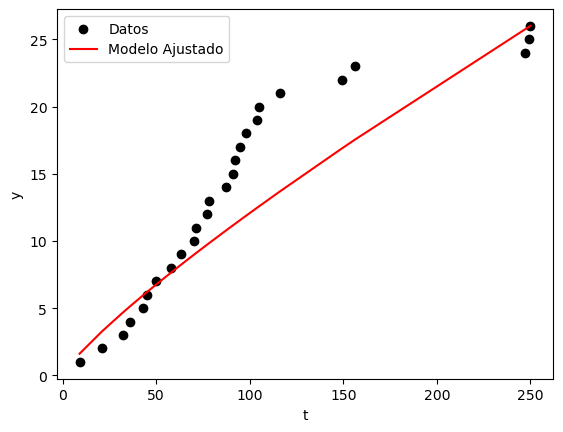

In [3]:
np.random.seed(123)

# Observation period
T = max(cum_days)
n = len(cum_days)

# Define the negative log-likelihood function
def neg_log_likelihood(params):
    a, c = params
    return a * (T**(c+1)) / (c+1) - n * np.log(a) - c * np.sum(np.log(cum_days))  

# Initial guess for parameters
initial_guess = [1.0, 1.0]

# Perform the optimization
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B')

# Extract the estimated parameters
a_est, c_est = result.x

print(f"Estimated a: {a_est}, mutiplicative term: {a_est/(c_est+1)}")
print(f"Estimated c: {c_est}, power term: {c_est+1}")

# Graficar los datos y el modelo ajustado para visualización
plt.scatter(cum_days, errors, label='Datos', color='black')
plt.plot(cum_days, a_est * cum_days ** (1 + c_est) / (1 + c_est), label='Modelo Ajustado', color='red')
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()

In [32]:
a_prima_est = a_est / (c_est + 1)
c_prima_est = c_est + 1
with pm.Model() as model:    
    a_prima = pm.Gamma('a_prima', alpha=100*a_prima_est**2, beta=100*a_prima_est) 
    c_prima = pm.Gamma('c_prima', alpha=100*c_prima_est**2, beta=100*c_prima_est)
    m_t = a_prima * cum_days ** c_prima

    # a = pm.Exponential('a', lam=a_est)  
    # c = pm.Normal('c', mu=c_est, sigma=0.1)  
    # m_t = a * cum_days ** (c+1)/(c+1)

    observed = pm.Poisson('observed', mu=m_t, observed=errors)
    
    trace = pm.sample(1000, tune=2000, target_accept=0.9, return_inferencedata=True)


# Analizar y visualizar los resultados del muestreo
az.plot_trace(trace)
plt.show()

# Resumen de la distribución posterior
summary = az.summary(trace, round_to=2)
print(summary)

# Extraer los valores medios de 'a' y 'c' de la distribución posterior
a_estimated = trace.posterior["a"].mean().item()
c_estimated = trace.posterior["c"].mean().item()

print("Estimación de 'a':", a_estimated)
print("Estimación de 'c':", c_estimated)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_prima, c_prima]


Output()

ParallelSamplingError: Chain 0 failed with: (34, 'Result too large')
Apply node that caused the error: Composite{...}([  9  21 ... 7 249 250], ExpandDims{axis=0}.0, ExpandDims{axis=0}.0, [ 1.  2. ... . 25. 26.], [ 0. ... .26170176], [2.1972245 ... .52146092])
Toposort index: 4
Inputs types: [TensorType(int32, shape=(26,)), TensorType(float64, shape=(1,)), TensorType(float64, shape=(1,)), TensorType(float64, shape=(26,)), TensorType(float64, shape=(26,)), TensorType(float64, shape=(26,))]
Inputs shapes: [(26,), (1,), (1,), (26,), (26,), (26,)]
Inputs strides: [(4,), (8,), (8,), (8,), (8,), (8,)]
Inputs values: ['not shown', array([39411.57521503]), array([36.90199987]), 'not shown', 'not shown', 'not shown']
Outputs clients: [[Sum{axes=None}(Composite{...}.0)], [All{axes=None}(Composite{...}.1)], [Switch(ExpandDims{axis=0}.0, Composite{...}.2, [-inf])], [Sum{axes=None}(Composite{...}.3)]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

array([[<Axes: >, None],
       [<Axes: xlabel='a', ylabel='c'>, <Axes: >]], dtype=object)

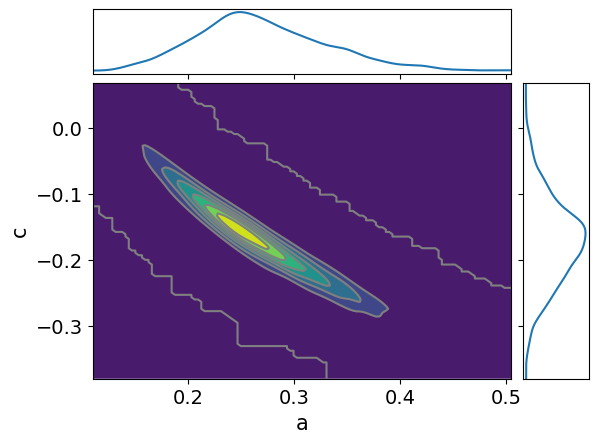

In [5]:
az.plot_pair(trace, divergences=True, kind='kde', marginals=True)

In [34]:
def sample_random_ac(trace, num_pairs):
    n_samples = trace.posterior.sizes["draw"]  # Número de muestras
    n_chains = trace.posterior.sizes["chain"]  # Número de cadenas

    # Seleccionar aleatoriamente pares de valores
    random_indices = np.random.choice(n_samples * n_chains, num_pairs)  # Índices aleatorios

    # Obtener los pares de valores
    random_ac = []
    for idx in random_indices:
        # Convertir el índice lineal a índice de cadena y muestra
        chain_index = idx // n_samples  # Índice de la cadena
        draw_index = idx % n_samples  # Índice de la muestra dentro de la cadena
        
        # Extraer valores de la cadena posterior
        a = trace.posterior["a"].isel(chain=chain_index, draw=draw_index).item()
        c = trace.posterior["c"].isel(chain=chain_index, draw=draw_index).item()
        
        random_ac.append((a, c))  # Almacenar el par
    return np.array(random_ac)

In [7]:
print(sample_random_ac(trace, 1000).mean(axis=0))
print(sample_random_ac(trace, 1000).min(axis=0))
print(sample_random_ac(trace, 1000).max(axis=0))
print(sample_random_ac(trace, 1000).std(axis=0))


[ 0.2667538  -0.16832949]
[ 0.12698666 -0.35554378]
[0.49094726 0.02937643]
[0.06326085 0.06555534]


In [35]:
def utility_func(x, rho1):
    if rho1 is None: 
        return x
    return (1 - np.exp(-rho1 * x)) / rho1

In [18]:
def compute_expected_utility_vec(t1, p1, lambda1, c11, c21, c31, n, T, ite=5000, rho1=None):    
    # Generating random variables for j=2,3
    ts = uniform.rvs(loc=0, scale=2000, size=(ite, 2))
    ps = uniform.rvs(loc=3000, scale=15000, size=(ite, 2))
    aes = norm.rvs(loc=0.256, scale=0.05, size=(ite, 2))
    aes[aes<0.01] = 0.01
    cs = norm.rvs(loc=0.837, scale=0.05, size=(ite, 2))
    lambda23T = aes * T ** cs
    lambda23t = aes * ts ** cs
    qs = poisson.rvs(lambda23T) - poisson.rvs(lambda23t)
    qs[qs<0.1] = 0

    # Generating buyer random variables
    w = dirichlet.rvs([1, 1, 1], size=ite)
    rho = gamma.rvs(5, scale=1/5, size=ite)

    # Generating random variables for j=1
    e1 = poisson.rvs(lambda1(t1), size=ite)
    eT = poisson.rvs(lambda1(T), size=ite)
    q1 = eT - e1
    q1[q1<0.1] = 0

    # Computing utility
    u1 = 1 - np.exp(-rho * (-w[:, 0] * t1 / T - w[:, 1] * p1 / 5000 - w[:, 2] * q1 / eT))
    u2 = 1 - np.exp(-rho * (-w[:, 0] * ts[:, 0] / T - w[:, 1] * ps[:, 0] / 5000 - w[:, 2] * qs[:, 0] / eT)) - u1
    u3 = 1 - np.exp(-rho * (-w[:, 0] * ts[:, 1] / T - w[:, 1] * ps[:, 1] / 5000 - w[:, 2] * qs[:, 1] / eT)) - u1

    # Computing probability of choice
    pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
    # Estimating the cost
    c1 = (c11 * t1 + c21 * e1 + c31 * q1).mean()

    # Estimating expected utility
    util = np.sum([comb(n, l) * pi**l * (1 - pi)**(n - l) * utility_func(l * p1 - c1, rho1) for l in range(n+1)])

    return util, pi

In [36]:
def compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=5000, rho1=None):    
    # Generating random variables for j=2,3
    ts = uniform.rvs(loc=0, scale=2000, size=(ite, 2))
    ps = uniform.rvs(loc=3000, scale=15000, size=(ite, 2))
    aes = norm.rvs(loc=0.256, scale=0.05, size=(ite, 2))
    aes[aes<0.01] = 0.01
    cs = norm.rvs(loc=0.837, scale=0.05, size=(ite, 2))
    lambda23T = aes * T ** cs
    lambda23t = aes * ts ** cs
    qs = poisson.rvs(lambda23T) - poisson.rvs(lambda23t)
    qs[qs<0.1] = 0

    # Generating buyer random variables
    w = dirichlet.rvs([1, 1, 1], size=ite)
    rho = gamma.rvs(5, scale=1/5, size=ite)

    # Generating random variables for j=1
    acs = sample_random_ac(trace, ite)
    lambda1_t1 = acs[:, 0] * t1 ** (acs[:, 1] + 1) / (acs[:, 1] + 1)
    lambda1_T = acs[:, 0] * T ** (acs[:, 1] + 1) / (acs[:, 1] + 1)
    e1 = poisson.rvs(lambda1_t1, size=ite)
    eT = poisson.rvs(lambda1_T, size=ite)
    q1 = eT - e1
    q1[q1<0.1] = 0

    # Computing utility
    u1 = 1 - np.exp(-rho * (-w[:, 0] * t1 / T - w[:, 1] * p1 / 5000 - w[:, 2] * q1 / eT))
    u2 = 1 - np.exp(-rho * (-w[:, 0] * ts[:, 0] / T - w[:, 1] * ps[:, 0] / 5000 - w[:, 2] * qs[:, 0] / eT)) - u1
    u3 = 1 - np.exp(-rho * (-w[:, 0] * ts[:, 1] / T - w[:, 1] * ps[:, 1] / 5000 - w[:, 2] * qs[:, 1] / eT)) - u1

    # Computing probability of choice
    pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
    # Estimating the cost
    c1 = (c11 * t1 + c21 * e1 + c31 * q1).mean()

    # Estimating expected utility
    util = np.sum([comb(n, l) * pi**l * (1 - pi)**(n - l) * utility_func(l * p1 - c1, rho1) for l in range(n+1)])

    return util, pi

In [43]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

# Example usage
t1 = 668.7224802667696
p1 = 10419.517164827266
random_ac = []
for i in range(2):
    util, _ = compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=100000)
    random_ac.append(util)

print(np.array(random_ac).mean(), np.array(random_ac).std())

C:\Users\pgarc\AppData\Local\Temp\ipykernel_1896\3415444743.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()


3420127.310121188 513.6593920176383


In [25]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

resultados = np.zeros((100 * 100, 4))
indice = 0
for p1 in np.linspace(3000, 15000, 100):
    for t1 in np.linspace(0, 2000, 100):
        util, prob = compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=10000)
        resultados[indice] = [p1, t1, util, prob]
        indice += 1

indice_mejor = np.argmax(resultados[:, 2])
mejor_datos = resultados[indice_mejor, :2]
mejor_util = resultados[indice_mejor, 2]
mejor_prob = resultados[indice_mejor, 3]

print("Mejores datos:", mejor_datos, "Mejor utilidad:", mejor_util, "Mejor probabilidad:", mejor_prob)
np.save('resultados.npy', resultados)

C:\Users\pgarc\AppData\Local\Temp\ipykernel_1896\3415444743.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()


Mejores datos: [10151.51515152   929.29292929] Mejor utilidad: 3464304.466521217 Mejor probabilidad: 0.3413558245900615


In [26]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

resultados = np.zeros((50 * 50, 4)) 
indice = 0
for p1 in np.linspace(9500, 11000, 50):
    for t1 in np.linspace(500, 1000, 50):
        util, prob = compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=10000)
        resultados[indice] = [p1, t1, util, prob]
        indice += 1

indice_mejor = np.argmax(resultados[:, 2])
mejor_datos = resultados[indice_mejor, :2]
mejor_util = resultados[indice_mejor, 2]
mejor_prob = resultados[indice_mejor, 3]

print("Mejores datos:", mejor_datos, "Mejor utilidad:", mejor_util, "Mejor probabilidad:", mejor_prob)
np.save('resultados_resolucion.npy', resultados)

C:\Users\pgarc\AppData\Local\Temp\ipykernel_1896\3415444743.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()


Mejores datos: [10234.69387755   551.02040816] Mejor utilidad: 3485064.531083048 Mejor probabilidad: 0.34060415979139613


In [6]:
resultados = np.load('resultados.npy')

In [7]:
indice_mejor = np.argmax(resultados[:, 2])
mejor_datos = resultados[indice_mejor, :2]
mejor_util = resultados[indice_mejor, 2]
mejor_prob = resultados[indice_mejor, 3]

print("Mejores datos:", mejor_datos, "Mejor utilidad:", mejor_util, "Mejor probabilidad:", mejor_prob)

Mejores datos: [10272.72727273   626.26262626] Mejor utilidad: 3394700.898126851 Mejor probabilidad: 0.33055079531541975


In [9]:
mejores_precios = []
for i in range(50):
    seleccion = resultados[abs(resultados[:, 1] - np.linspace(0, 2000, 100)[i]) < 1e-1]    
    mejores_precios.append(seleccion[np.argmax(seleccion[:, 2]), 0])

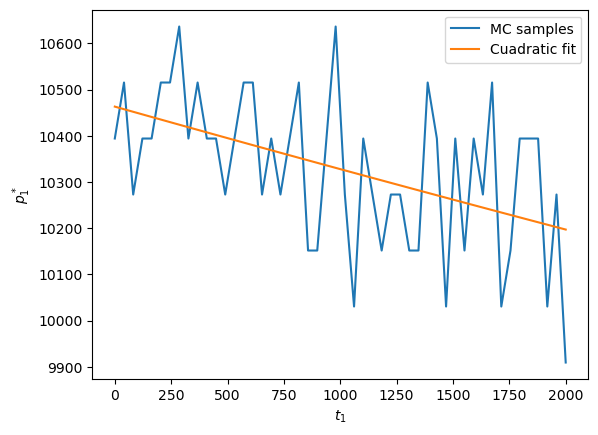

In [10]:
xs = np.linspace(0, 2000, 50)
c, b, a = np.polyfit(xs, mejores_precios, 2)
ys = a + b * xs + c * xs ** 2

plt.plot(np.linspace(0, 2000, 50), mejores_precios)
plt.plot(xs, ys)
plt.xlabel('$t_1$')
plt.ylabel('$p^*_1$')
plt.legend(['MC samples', 'Cuadratic fit'])

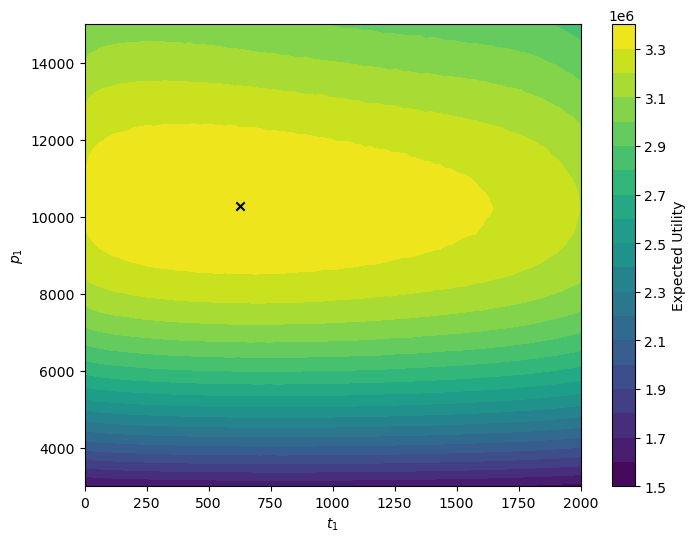

In [8]:
p1_vals = resultados[:, 0]
t1_vals = resultados[:, 1]
util_vals = resultados[:, 2]

p1_unique = np.unique(p1_vals)
t1_unique = np.unique(t1_vals)
util_matrix = util_vals.reshape(len(p1_unique), len(t1_unique))

plt.figure(figsize=(8, 6))
contourf = plt.contourf(t1_unique, p1_unique, util_matrix, levels=20, cmap='viridis')
plt.colorbar(contourf, label='Expected Utility')
plt.scatter(mejor_datos[1], mejor_datos[0], marker='x', c='black')
plt.xlabel('$t_1$')
plt.ylabel('$p_1$')
plt.show()

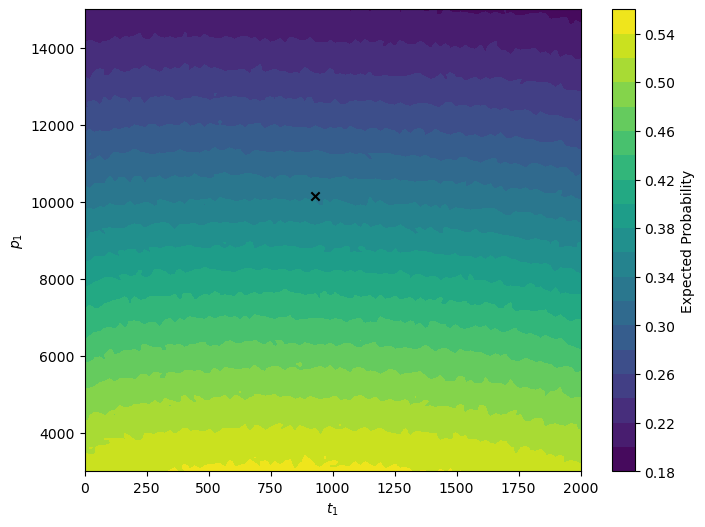

In [34]:
p1_vals = resultados[:, 0]
t1_vals = resultados[:, 1]
prob_vals = resultados[:, 3]

p1_unique = np.unique(p1_vals)
t1_unique = np.unique(t1_vals)
prob_matrix = prob_vals.reshape(len(p1_unique), len(t1_unique))

plt.figure(figsize=(8, 6))
contourf = plt.contourf(t1_unique, p1_unique, prob_matrix, levels=20, cmap='viridis')
plt.colorbar(contourf, label='Expected Probability')
plt.scatter(mejor_datos[1], mejor_datos[0], marker='x', c='black')
plt.xlabel('$t_1$')
plt.ylabel('$p_1$')
plt.show()

C:\Users\pgarc\AppData\Local\Temp\ipykernel_1896\3415444743.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()


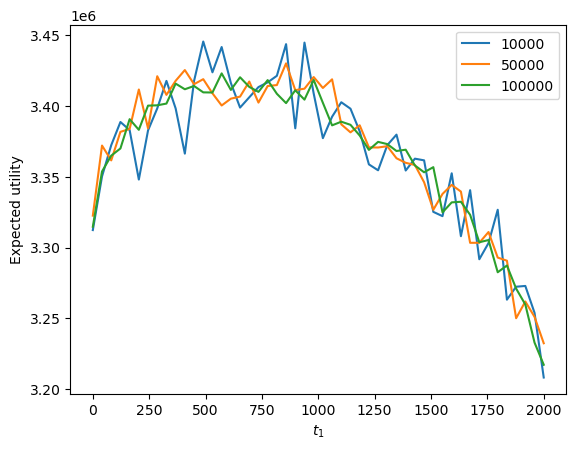

In [28]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

utils = []
utils_vec = []
utils_est = []
p1 = 10235
for t1 in np.linspace(0, 2000, 50):
    utils.append(compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=10000))
    utils_vec.append(compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=50000))
    utils_est.append(compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=100000))

plt.plot(np.linspace(0, 2000, 50), [u[0] for u in utils])
plt.plot(np.linspace(0, 2000, 50), [u[0] for u in utils_vec])
plt.plot(np.linspace(0, 2000, 50), [u[0] for u in utils_est])
plt.xlabel('$t_1$')
plt.ylabel('Expected utility')
plt.legend([10000, 50000, 100000])

In [27]:
c11 = 0.5
c21 = 1
c31 = 5
n = 1000
T = 2000

resultados = np.zeros((7 * 20 * 20, 5)) 
indice = 0

rhos = [-1e-6, -1e-7, -1e-8, None, 1e-8, 1e-7, 1e-6]
for rho1 in rhos:
    print(rho1)
    for p1 in np.linspace(9500, 12000, 20):
        for t1 in np.linspace(500, 1000, 20):
            util, prob = compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=10000, rho1=rho1)
            resultados[indice] = [p1, t1, util, prob, rho1]
            indice += 1
np.save('resultados_rhos.npy', resultados)

-1e-06


C:\Users\pgarc\AppData\Local\Temp\ipykernel_1896\3415444743.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()


-1e-07
-1e-08
None
1e-08
1e-07
1e-06


In [35]:
resultados_rho = np.load('resultados_rhos.npy')

rhos = [-1e-6, -1e-7, -1e-8, None, 1e-8, 1e-7, 1e-6]
for rho in rhos:
    if rho is None:
        seleccion = resultados_rho[np.isnan(resultados_rho[:,4])]   
    else:
        seleccion = resultados_rho[resultados_rho[:, 4] == rho]    
    
    indice_mejor = np.argmax(seleccion[:, 2])
    mejor_datos = seleccion[indice_mejor, :2]
    mejor_util = seleccion[indice_mejor, 2]
    mejor_prob = seleccion[indice_mejor, 3]

    print("Rho:", rho, "Mejores datos:", mejor_datos, "Mejor utilidad:", mejor_util, "Mejor probabilidad:", mejor_prob)

Rho: -1e-06 Mejores datos: [10026.31578947   710.52631579] Mejor utilidad: 31551707.90426628 Mejor probabilidad: 0.3463261621856519
Rho: -1e-07 Mejores datos: [11078.94736842   500.        ] Mejor utilidad: 4140993.7662214274 Mejor probabilidad: 0.3127116546567091
Rho: -1e-08 Mejores datos: [10157.89473684   789.47368421] Mejor utilidad: 3526220.1811961737 Mejor probabilidad: 0.34124252546151346
Rho: None Mejores datos: [10684.21052632   631.57894737] Mejor utilidad: 3461489.422280134 Mejor probabilidad: 0.32406830737974973
Rho: 1e-08 Mejores datos: [10421.05263158   789.47368421] Mejor utilidad: 3413346.214934495 Mejor probabilidad: 0.3333667402392842
Rho: 1e-07 Mejores datos: [10815.78947368   605.26315789] Mejor utilidad: 2944892.7018875787 Mejor probabilidad: 0.3227256824574094
Rho: 1e-06 Mejores datos: [10552.63157895   605.26315789] Mejor utilidad: 968030.8540157867 Mejor probabilidad: 0.32751588327812103


In [39]:
from skopt import gp_minimize
from skopt.space import Real
from functools import partial

# Define the parameter space
space = [Real(3000, 15000, name='p1'), Real(0, 2000, name='t1')]
    
c11 = 0.5
c21 = 1
c31 = 5
n = 1000  
T = 2000

# Define the objective function wrapper for skopt
def objective_function(params, c11, c21, c31, n, T):
    p1, t1 = params
    return -compute_expected_utility_vec_random_ac(t1, p1, c11, c21, c31, n, T, ite=10000)[0]

# Define partial function for passing extra parameters to the objective function
objective_function_partial = partial(objective_function, c11=c11, c21=c21, c31=c31, n=n, T=T)

# Perform Bayesian optimization
result = gp_minimize(objective_function_partial, space, n_calls=200)

# Get the optimal parameters
p1_optimal, t1_optimal = result.x
optimal_utility = -result.fun

print("Optimal p1:", p1_optimal)
print("Optimal t1:", t1_optimal)
print("Optimal utility:", optimal_utility)

C:\Users\pgarc\AppData\Local\Temp\ipykernel_1896\3415444743.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
C:\Users\pgarc\AppData\Local\Temp\ipykernel_1896\3415444743.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
C:\Users\pgarc\AppData\Local\Temp\ipykernel_1896\3415444743.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
C:\Users\pgarc\AppData\Local\Temp\ipykernel_1896\3415444743.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
C:\Users\pgarc\AppData\Local\Temp\ipykernel_1896\3415444743.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
C:\Users\pgarc\AppData\Local\Temp\ipykernel_1896\3415444743.py:32: RuntimeWarning: overflow encountered in exp
  pi = (1 / (1 + np.exp(u2) + np.exp(u3))).mean()
C:\Users\pgarc\AppData\Local\Temp\

Optimal p1: 10419.517164827266
Optimal t1: 668.7224802667696
Optimal utility: 3483799.4904361316


In [50]:
def generate_neighbor(t1, p1):
    # Generate a neighboring solution by perturbing t1 and p1 within a certain range
    new_t1 = np.clip(t1 + np.random.uniform(-50, 50), 0, 2000)
    new_p1 = np.clip(p1 + np.random.uniform(-200, 200), 3000, 15000)
    return new_t1, new_p1

def simulated_annealing(initial_t1, initial_p1, c11, c21, c31, n, T, max_iter=1000):
    # Set initial temperature and cooling rate
    temperature = 1000
    cooling_rate = 0.99

    # Initialize current solution
    current_t1, current_p1 = initial_t1, initial_p1
    current_util = compute_expected_utility_vec_random_ac(current_t1, current_p1, c11, c21, c31, n, T, ite=10000)[0]

    # Initialize best solution
    best_t1, best_p1 = current_t1, current_p1
    best_util = current_util

    # Simulated Annealing algorithm
    for _ in tqdm.tqdm(range(max_iter)):
        # Generate a neighboring solution
        new_t1, new_p1 = generate_neighbor(current_t1, current_p1)

        # Calculate the cost of the new solution
        new_util = compute_expected_utility_vec_random_ac(new_t1, new_p1, c11, c21, c31, n, T, ite=10000)[0]

        # Calculate the acceptance probability
        delta_util = new_util - current_util
        acceptance_probability = np.exp(delta_util / temperature)

        # Accept or reject the new solution
        if np.random.uniform() < acceptance_probability:
            current_t1, current_p1 = new_t1, new_p1
            current_util = new_util

        # Update the best solution
        if current_util > best_util:
            best_t1, best_p1 = current_t1, current_p1
            best_util = current_util

        # Cool down the temperature
        temperature *= cooling_rate

    return best_t1, best_p1

# Example usage
initial_t1 = np.random.uniform(0, 2000)
initial_p1 = np.random.uniform(3000, 15000)
best_t1, best_p1 = simulated_annealing(initial_t1, initial_p1, c11, c21, c31, n, T)
print("Best t1:", best_t1)
print("Best p1:", best_p1)

  0%|          | 1/1000 [00:06<1:52:20,  6.75s/it]


KeyboardInterrupt: 